In [879]:
import pandas as pd
import numpy as np
import glob
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from datetime import datetime as dt
import unidecode
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import string
import cv2


import re
import pickle

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve, f1_score, plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import Normalize

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import hstack
from scipy.special import logit, expit

# from my_nmf import NMF
# from helpers import build_text_vectorizer, hand_label_topics, analyze_article

plt.style.use('seaborn')
# os.chdir("data")

ModuleNotFoundError: No module named 'cv2'

In [2]:
file = 'data/comments.csv'
df = pd.read_csv(file, names = ['Text', 'ID', 'Subreddit', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes', 'Author_link_karma', 'Author_Comment_Karma','Author_has_gold?'], parse_dates =True, encoding = 'utf-8')


In [516]:
df = df.dropna(axis =0)

# make meta dataframes

In [479]:
df_entertainment = df.dropna(axis =0).loc[df['meta']== 'entertainment']
# df_entertainment.Text
df

In [488]:
df_news = df.dropna(axis =0).loc[df['meta']== 'news']


In [624]:
df_lifestyle = df.dropna(axis =0).loc[df['meta']== 'lifestyle']


In [489]:
df_learning = df.dropna(axis =0).loc[df['meta']== 'learning']


In [490]:
df_humor = df.dropna(axis =0).loc[df['meta']== 'humor']
df_humor.shape

In [491]:
df_television = df.dropna(axis =0).loc[df['meta']== 'television']
df_television.shape

In [492]:
df_gaming = df.dropna(axis =0).loc[df['meta']== 'gaming']
df_gaming.shape

# Proper Pipeline, no alaska

In [160]:
def clean_urls(array):
    lst = []
    for string in array:
#         remove url strings
        if string > re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE):
            string = re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
#           remove extra youtube v's
            string = re.sub(r'v = () ', '', string, flags = re.MULTILINE)
            lst.append(string)
        else: 
            string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
            lst.append(string)
    return lst
# test
# tokelems = clean_urls(df_entertainment.Text.values)
# cleaned_urls
# type(cleaned_urls[1])

In [665]:
punctuations = '''.!=-()[]{};:"|\<>/?@#$%^&*_~'''
replace = '{}'.format('\n')
lst = []

test_strings = ['James ran ForWard from the https://  !!! $ %   youtube.com v asfhabjf v asvjdakbfakdfasdfbasdfadfsasfadga %666^^ 32$']
test_strings2 = df_entertainment.Text.values[:2]
# print(test_strings2)

def base_clean_up(strings):
    new_strings = [] 
    for i in strings:
#         lower the strings
        i = i.lower()
#         convert strings to unicode
        i = unidecode.unidecode(i)
#         remove extra spaces
        i = re.sub(" +", " ", i)
        no_punct = ""
        for word in i.split():
#             remove any individual letters or extra spaces
            word = re.sub(r'[^\w\s]','',word)
            
            if len(word) > 20:
                word = ""
            no_punct += f'{word} '
        new_strings.append(no_punct)
#         print(no_punct)
    return new_strings



# # test check
clean_test = base_clean_up(test_strings)
print(clean_test)
# check using df
# tokelems = base_clean_up(tokelems)  
# base_clean_up1
# clean_test

['james ran forward from the https    youtubecom v asfhabjf v  666 32 ']


In [640]:
s_stop = set(stopwords.words())
print(len(s_stop))
new_stops = ['politics', 'libertarian', 'worldnews', 'offbeat', 'news',
       'truereddit', 'conspiracy', 'conservative', 'frugal',
       'motorcycles', 'sex', 'drunk', 'food', 'lifehacks', 'guns',
       'progresspics', 'askscience', 'science', 'explainlikeimfive',
       'askhistorians', 'youshouldknow', 'todayilearned', 'space',
       'circlejerk', 'facepalm', 'jokes', 'adviceanimals', 'funny',
       'imgoingtohellforthis', 'movies', 'harrypotter', 'music', 'anime',
       'comicbooks', 'starwars', 'doctorwho', 'community', 'breakingbad',
       'thewalkingdead', 'startrek', 'mylittlepony', 'gameofthrones',
       'himym', 'tf2', 'dota2', 'leagueoflegends', 'minecraft', 'pokemon',
       'gaming', 'skyrim', 'starcraft','nt','like', 'really', '2015ref',
        'publisherspage190ref','volume9', 'issue2','005', '1671', '2015', 
        'jpgthumbemerg', 'jpgthumbrightth', 'logo', 'page7','logo.png','2015.ref', 
        'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 
        'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', 
        '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-',
        'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 
        'refimprovedatemay','ligatureligatur','amazing', 'awesome', 'bad', 'best', 'better', 'bit', 
        'character', 'cool', 'day', 'end', 'episode', 'feel', 'film', 'going', 'good', 'great', 'know', 
        'life', 'little', 'll', 'looks', 'love', 'make', 'man', 'music', 'new', 'people', 'pretty', 'read', 
        'right', 'saw', 'scene', 'seen', 'sure', 'think', 'thought', 'want', 'wars', 'way', 'come', 'jpg','10',
        '11','12', 'amp', 'days', 'edit', 'far', 'gets', 'fun', 'getting','let', 'later', 'makes', 'men', 'na',
        'oh', 'op', 'post', 'reddit', 'said', 'remember', 'sorry', 'start', 'started', 'stop', 'tell', 'stuff',
        'took', 'try','use', 'used', 'wait', 'wanted', 'week','went', 'yeah', 'yes', 'work', 'world', 
        'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob','baiknya', 
        'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद', 'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम', 'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन', 'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल', 'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत', 'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष', 'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत', 'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर', 'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक', 'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन', 'हर', 'हरण', 'ἀλλ']
for i in new_stops:
    s_stop.add(i)
    
print(len(s_stop))

6255
6595


In [163]:
def tokenizer(strings):
        lst = []
        for i in strings:
            tokens = [word for word in i.split(" ") if word not in s_stop]
            lst.append(tokens)
        return lst

# # test tokenizer 
tokelems = tokenizer(tokelems)
# print(test_tokes)
#     lst.append(no_punct)
# df_entertainment.Text = lst

In [164]:
def lemmatization(tokens):
#     for i in tokens:
    
    lems = [[lemmatizer.lemmatize(word) for word in sent] for sent in tokens]
    return lems
tokelems = lemmatization(tokelems)


# Pipeline

In [495]:
def piped(arr):
    arr = clean_urls(arr)
    arr = base_clean_up(arr)
    tokens = tokenizer(arr)
    lems = lemmatization(tokens)
    lst_final = []
    for i in lems:
        i = " ".join(i)
        lst_final.append(i)
    return lst_final

# add 'tokelems' to individual dataframes

In [740]:
df['tokelems'] = piped(df.Text.values)

In [657]:
df_news['tokelems'] = piped(df_news.Text.values)

In [658]:
df_humor['tokelems'] = piped(df_humor.Text.values)

In [659]:
df_lifestyle['tokelems'] = piped(df_lifestyle.Text.values)

In [660]:
df_television['tokelems'] = piped(df_television.Text.values)

In [661]:
df_entertainment['tokelems'] = piped(df_entertainment.Text.values)

In [662]:
df_gaming['tokelems'] = piped(df_gaming.Text.values)

In [663]:
df_learning['tokelems'] = piped(df_learning.Text.values)

### create samples if you want to test on smaller data set quickly

In [ ]:
x_meta = tfidf_vectorizer.fit_transform(df['tokelems']).toarray()
rfc_

# predict meta

In [541]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.965, min_df=.015, stop_words=new_stops)

In [741]:
x_meta = tfidf_vectorizer.fit_transform(df['tokelems']).toarray()
feats_meta = tfidf_vectorizer.get_feature_names()

# Gaming

In [753]:
y_meta_gaming = df['meta_gaming']
X_train_gaming, X_test_gaming, y_train_gaming, y_test_gaming = train_test_split(x_meta, y_meta_gaming, test_size=0.20)

In [754]:
rfc_meta_gaming = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_gaming.fit(X_train_gaming, y_train_gaming)
rfc_meta_gaming.oob_score_

0.8509824279517096

In [743]:
sorted(list(zip(rfc_meta_gaming.feature_importances_, feats_meta)))

[(0.004821735781949641, 'job'),
 (0.004916527852914273, 'different'),
 (0.005197629893645958, 'looking'),
 (0.005675798671240562, 'else'),
 (0.005820072484920765, 'enough'),
 (0.005916655564534491, 'everyone'),
 (0.005917101647419786, 'may'),
 (0.005961421373314505, 'hard'),
 (0.00599621051269973, 'might'),
 (0.006007647242206605, 'big'),
 (0.006010326189663184, 'everything'),
 (0.006016681875743121, 'least'),
 (0.006104713968043671, 'reason'),
 (0.006106251737369379, 'fucking'),
 (0.00613422755312064, 'money'),
 (0.006262395351390746, 'long'),
 (0.006306329573052639, 'question'),
 (0.006340428164238054, 'seems'),
 (0.006412704954393561, 'anything'),
 (0.006594792737060608, 'done'),
 (0.006816220042122501, 'part'),
 (0.006881787983247647, 'place'),
 (0.006903715758037396, 'point'),
 (0.006942352935306974, 'friend'),
 (0.006952623616763545, 'idea'),
 (0.007097864833453234, 'two'),
 (0.007122975601190701, 'old'),
 (0.007190178024250177, 'another'),
 (0.007241748906244446, 'without'),
 (0

In [756]:
print(cross_val_score(rfc_meta_gaming, X_test_gaming, y_test_gaming, cv=3))

[0.85015678 0.84970109 0.85098171]


### Gaming visualization

In [796]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, accuracy_score, precision_score, recall_score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [797]:
# Create prediction array.
preds_gaming = rfc_meta_gaming.predict(X_test_gaming)

# Use the sklearn confusion matrix class to create a confusion matrix, call the variable "cm"
# so it works with the last line of this cell
cm = confusion_matrix(y_test_gaming, preds_gaming)

#Print the accuracy_score and f1 score
print("Model precision {}".format(precision_score(y_test_gaming, preds_gaming)))
print("Model recall {}".format(recall_score(y_test_gaming, preds_gaming)))



Model precision 0.9108964167787698
Model recall 0.3424583214558295


In [793]:
cm

array([[388930,   3643],
       [ 71507,  37242]])

# Entertainment

In [757]:
y_meta_ent = df['meta_entertainment']
X_train_ent, X_test_ent, y_train_ent, y_test_ent = train_test_split(x_meta, y_meta_ent, test_size=0.20)

In [758]:
y_meta_ent = df['meta_entertainment']
rfc_meta_entertainment = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_entertainment.fit(X_train_ent, y_train_ent)
rfc_meta_entertainment.oob_score_

0.9010111769537228

In [745]:
sorted(list(zip(rfc_meta_entertainment.feature_importances_, feats_meta)))

[(0.005930525304617422, 'problem'),
 (0.006371317020606162, 'play'),
 (0.006442130362635647, 'change'),
 (0.007017786444899626, 'job'),
 (0.0070554470629204495, 'long'),
 (0.00719647886759506, 'away'),
 (0.00728787175290564, 'money'),
 (0.00732500631930878, 'hard'),
 (0.007368499987234982, 'fuck'),
 (0.007509878888094168, 'idea'),
 (0.007761846070007444, 'may'),
 (0.007886884947200648, 'without'),
 (0.007995558511062307, 'around'),
 (0.008000182239407556, 'different'),
 (0.008119551269328382, 'place'),
 (0.008131210252243677, 'else'),
 (0.008250175905493816, 'old'),
 (0.008456029946277642, 'big'),
 (0.00856879133704029, 'mean'),
 (0.008614184749385849, 'reason'),
 (0.008691682299100856, 'question'),
 (0.008736704853308713, 'help'),
 (0.008773718916311202, 'anything'),
 (0.008777671745503902, 'least'),
 (0.00904655893590092, 'keep'),
 (0.009059598434601654, 'fucking'),
 (0.009123742411800324, 'everyone'),
 (0.009269185355861416, 'done'),
 (0.009539981164741605, 'anyone'),
 (0.0095589889

In [784]:
print(cross_val_score(rfc_meta_entertainment, X_test_ent, y_test_ent, cv=3))

[0.90195562 0.90166779 0.90127284]


In [798]:
# Create prediction array.
preds_ent = rfc_meta_entertainment.predict(X_test_ent)

# Use the sklearn confusion matrix class to create a confusion matrix, call the variable "cm"
# so it works with the last line of this cell
cm_ent = confusion_matrix(y_test_ent, preds_ent)
tn, fp, fn, tp = cm
cm_ent = np.array([tp, ])
array([[388930,   3643],
       [ 71507,  37242]])

#Print the accuracy_score and f1 score
print("Model precision {}".format(precision_score(y_test_ent, preds_ent)))
print("Model recall {}".format(recall_score(y_test_ent, preds_ent)))


Model precision 0.9300137768155875
Model recall 0.3316628765546478


In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix()

# Humor

In [760]:
y_meta_humor = df['meta_humor']
X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(x_meta, y_meta_humor, test_size=0.20)

In [761]:
# y_meta_humor = df['meta_humor']
rfc_meta_humor = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_humor.fit(X_train_hum, y_train_hum)
rfc_meta_humor.oob_score_

0.8847411866730298

In [747]:
sorted(list(zip(rfc_meta_humor.feature_importances_, feats_meta)))

[(0.006096559845993284, 'problem'),
 (0.006336960679442734, 'change'),
 (0.00639269898568565, 'play'),
 (0.006775760318966552, 'job'),
 (0.007080255360804618, 'money'),
 (0.007159294522834042, 'hard'),
 (0.007303450080398889, 'away'),
 (0.007388139970983847, 'fuck'),
 (0.007633718556378671, 'idea'),
 (0.007707077976850657, 'without'),
 (0.007932302188838997, 'long'),
 (0.008021164906320643, 'around'),
 (0.00809819768239004, 'different'),
 (0.008161279587386822, 'may'),
 (0.00834842555021433, 'old'),
 (0.008443848696818938, 'else'),
 (0.008449400191289893, 'reason'),
 (0.00854939821987684, 'question'),
 (0.008600286920369267, 'place'),
 (0.008688792606695696, 'help'),
 (0.008692806454596462, 'big'),
 (0.008885328905603482, 'mean'),
 (0.008895956751250883, 'least'),
 (0.008965804581678656, 'fucking'),
 (0.008966842456210065, 'anything'),
 (0.009113084025941829, 'everyone'),
 (0.009170995123228208, 'someone'),
 (0.009379703062023839, 'keep'),
 (0.009503364496642594, 'nice'),
 (0.009530046

In [762]:
print(cross_val_score(rfc_meta_humor, X_test_hum, y_test_hum, cv=3))

[0.88469732 0.88534891 0.88479238]


# Learning

In [765]:
y_meta_learn = df['meta_learning']
X_train_learn, X_test_learn, y_train_learn, y_test_learn = train_test_split(x_meta, y_meta_learn, test_size=0.20)

In [767]:
y_train_learn.shape

(2005287,)

In [770]:
# y_meta_learn = df['meta_learning']
rfc_meta_learn = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_learn.fit(X_train_learn, y_train_learn)
rfc_meta_learn.oob_score_

0.9445500818586068

In [749]:
sorted(list(zip(rfc_meta_humor.feature_importances_, feats_meta)))

[(0.006096559845993284, 'problem'),
 (0.006336960679442734, 'change'),
 (0.00639269898568565, 'play'),
 (0.006775760318966552, 'job'),
 (0.007080255360804618, 'money'),
 (0.007159294522834042, 'hard'),
 (0.007303450080398889, 'away'),
 (0.007388139970983847, 'fuck'),
 (0.007633718556378671, 'idea'),
 (0.007707077976850657, 'without'),
 (0.007932302188838997, 'long'),
 (0.008021164906320643, 'around'),
 (0.00809819768239004, 'different'),
 (0.008161279587386822, 'may'),
 (0.00834842555021433, 'old'),
 (0.008443848696818938, 'else'),
 (0.008449400191289893, 'reason'),
 (0.00854939821987684, 'question'),
 (0.008600286920369267, 'place'),
 (0.008688792606695696, 'help'),
 (0.008692806454596462, 'big'),
 (0.008885328905603482, 'mean'),
 (0.008895956751250883, 'least'),
 (0.008965804581678656, 'fucking'),
 (0.008966842456210065, 'anything'),
 (0.009113084025941829, 'everyone'),
 (0.009170995123228208, 'someone'),
 (0.009379703062023839, 'keep'),
 (0.009503364496642594, 'nice'),
 (0.009530046

In [776]:
print(cross_val_score(rfc_meta_learn, X_test_learn, y_test_learn, cv=3))

[0.94390454 0.94380247 0.94416751]


# News

In [771]:
y_meta_news = df['meta_news']
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(x_meta, y_meta_news, test_size=0.20)

In [772]:
# y_meta_news = df['meta_news']
rfc_meta_news = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_news.fit(X_train_news, y_train_news)
rfc_meta_news.oob_score_

0.9077194436507093

In [751]:
sorted(list(zip(rfc_meta_news.feature_importances_, feats_meta)))

[(0.0044202799958007345, 'friend'),
 (0.004947082330848768, 'looking'),
 (0.004976859074104878, 'nice'),
 (0.005011064006277879, 'play'),
 (0.0059904905527886744, 'question'),
 (0.0068191451561053365, 'different'),
 (0.006881297204158495, 'else'),
 (0.00701375961271807, 'hard'),
 (0.0076963793428480205, 'maybe'),
 (0.007702635824951783, 'done'),
 (0.007905399319956968, 'show'),
 (0.00800817621328952, 'least'),
 (0.008092876267103474, 'place'),
 (0.008268207677164352, 'old'),
 (0.008350915685344651, 'away'),
 (0.008402886364404963, 'everything'),
 (0.00858731718757263, 'last'),
 (0.008675577579811564, 'though'),
 (0.00869165024814813, 'part'),
 (0.008878726056654008, 'enough'),
 (0.008956948665876222, 'fucking'),
 (0.009005241704992836, 'look'),
 (0.009175609575318922, 'change'),
 (0.009223054551267361, 'already'),
 (0.009246168572271726, 'long'),
 (0.009259034309127221, 'made'),
 (0.009522795733815238, 'reason'),
 (0.0096398389995773, 'might'),
 (0.009646720320064783, 'fuck'),
 (0.0097

In [777]:
print(cross_val_score(rfc_meta_news, X_test_news, y_test_news, cv=3))

[0.90713191 0.90745451 0.90732285]


# TV

In [775]:
y_meta_tv = df['meta_television']
X_train_tv, X_test_tv, y_train_tv, y_test_tv = train_test_split(x_meta, y_meta_tv, test_size=0.20)

In [778]:
# y_meta_tv = df['meta_television']
rfc_meta_tv = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_tv.fit(X_train_tv, y_train_tv)
rfc_meta_tv.oob_score_

0.9224350429639249

In [ ]:
sorted(list(zip(rfc_meta_tv.feature_importances_, feats_meta)))

In [779]:
print(cross_val_score(rfc_meta_tv, X_test_tv, y_test_tv, cv=3))

[0.92307968 0.92302537 0.92257057]


# Lifestyle

In [781]:
y_meta_life = df['meta_lifestyle']
X_train_life, X_test_life, y_train_life, y_test_life = train_test_split(x_meta, y_meta_life, test_size=0.20)

In [782]:
y_meta_life = df['meta_lifestyle']
rfc_meta_life = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_life.fit(X_train_life, y_train_life)
rfc_meta_life.oob_score_

0.9133395868022881

In [ ]:
sorted(list(zip(rfc_meta_life.feature_importances_, feats_meta)))

In [783]:
print(cross_val_score(rfc_meta_life, X_test_life, y_test_life, cv=3))

[0.91324174 0.91198454 0.91307366]


In [ ]:
meta_model_names = ['Gaming', 'Entertainment', 'Humor', 'Learning', 'News', 'Television', 'Lifestyle']
meta_models = [rfc_meta_gaming, rfc_meta_entertainment,rfc_meta_humor, rfc_meta_learn, rfc_meta_news, rfc_meta_tv, rfc_meta_life]

# predict meta


In [ ]:
x_meta = tfidf_vectorizer.fit_transform(df['tokelems']).toarray()

In [814]:
game_string = ['Gears of war and halo were my childhood. i loved playing those games on the xbox more than anything. everyday my brothers and i would play together. we beat the campaign']
anime_strings = ['Little Witch Academia is the best anime ever written. its just like harry potter for weebs']
politic_string = ['i am still not sure if bernie sanders is the candidate for me. clinton and other more typical democrats really tend to speak more to me than those on the far left. furthermore, i dont like the idea of socialism']
random_string = ['Little Witch Academia is a great show. i love watching it with my family and it is so much better than harry potter ever was. when i get home to watch this anime with my family, i truly feel like it is an surreal experience. other anime and movies and cartoons cannot compare']
def predict_meta(test_strings):
    test_strings = clean_urls(Test_strings)
    test_strings = base_clean_up(test_strings)
    test_strings = tokenizer(test_strings)
    test_strings = lemmatization(test_strings)
    lsttest =[]
    for i in test_strings:
        i = " ".join(i)
        lsttest.append(i)
    
    vectors = tfidf_vectorizer.transform(lsttest).toarray()
    meta_model_names = ['Gaming', 'Entertainment', 'Humor', 'Learning', 'News', 'Television', 'Lifestyle']
    meta_models = [rfc_meta_gaming, rfc_meta_entertainment,rfc_meta_humor, rfc_meta_learn, rfc_meta_news, rfc_meta_tv, rfc_meta_life]    

    probs = []
    for i in meta_models:
        probs.append(i.predict_proba(vectors))
    return (list(zip(probs, meta_model_names)))
predict_meta(politic_string)

[(array([[0.82636327, 0.17363673]]), 'Gaming'),
 (array([[0.7880882, 0.2119118]]), 'Entertainment'),
 (array([[0.88546995, 0.11453005]]), 'Humor'),
 (array([[0.90545273, 0.09454727]]), 'Learning'),
 (array([[0.90928748, 0.09071252]]), 'News'),
 (array([[0.79710595, 0.20289405]]), 'Television'),
 (array([[0.8924007, 0.1075993]]), 'Lifestyle')]

Instantiate vectorizer

In [808]:
df_entertainment.Subreddit.unique()

array(['movies', 'harrypotter', 'music', 'anime', 'comicbooks',
       'starwars'], dtype=object)

# Testing the entertainment column

### Entertainment

In [888]:
dummiezed

,Text,ID,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?,Tokelems,Subreddit_anime,Subreddit_comicbooks,Subreddit_harrypotter,Subreddit_movies,Subreddit_music,Subreddit_starwars
1446458,i can not wait to see him whoop some intergala...,d02nuw8,entertainment,1.455673e+09,cmonster1697,1.0,0.0,488.0,8426.0,0.0,wait see whoop intergalactic alien butt rogue ...,0,0,0,1,0,0
1446459,amazing cinematographer. one of the best to ev...,d02q51i,entertainment,1.455676e+09,BrodoFagginsIsMyName,1.0,0.0,1.0,457.0,0.0,amazing cinematographer best ever,0,0,0,1,0,0
1446463,you 've finally had your life changed .,d02uuym,entertainment,1.455684e+09,BrodoFagginsIsMyName,3.0,0.0,1.0,457.0,0.0,finally life changed,0,0,0,1,0,0
1446464,that is awesome ! thanks !,d02ftgc,entertainment,1.455661e+09,JeopardyThis,3.0,0.0,1.0,-7.0,0.0,awesome thanks,0,0,0,1,0,0
1446465,"that tom cruise 's character , john anderton ,...",465qz3,entertainment,1.455672e+09,tangowhiskey33,16.0,0.0,7346.0,6138.0,0.0,tom cruise character john anderton kidnaps p...,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826308,i love it ! ! !,d026lj4,entertainment,1.455648e+09,elbowsss,2.0,0.0,2212.0,8637.0,1.0,love,0,0,1,0,0,0
1826309,you are the type of ra i hope i can be if i ma...,d02qfaf,entertainment,1.455677e+09,DEP61,2.0,0.0,5581.0,13488.0,0.0,type ra hope manage get selected current ra g...,0,0,1,0,0,0
1826310,this was my bulletin board for the month too :...,d02rem2,entertainment,1.455678e+09,laneebird,2.0,0.0,43.0,8.0,0.0,bulletin board month p,0,0,1,0,0,0
1826311,that 's so excellent ! i would be so pleased t...,d02ecuj,entertainment,1.455659e+09,GoodniteMush,1.0,0.0,1.0,681.0,0.0,excellent would pleased find first day great ...,0,0,1,0,0,0


## Entertainment

In [848]:
X_ent = tfidf_vectorizer.fit_transform(dummiezed['Tokelems']).toarray()
feats_ent = tfidf_vectorizer.get_feature_names()

### Anime

In [824]:
y_anime = dummiezed['Subreddit_anime']
X_train_anime, X_test_anime, y_train_anime, y_test_anime = train_test_split(X_ent, y_anime, test_size=0.20)

In [853]:
print(X_train_anime.shape, X_test_anime.shape, y_train_anime.shape, y_test_anime.shape)
print(X_ent.shape)

(286137, 110) (71535, 110) (286137,) (71535,)
(357672, 160)


In [827]:
rfc_anime =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_anime.fit(X_train_anime, y_train_anime)

print(cross_val_score(rfc_anime, X_test_anime, y_test_anime, cv=3, scoring = 'f1'))


[0.69593079 0.6987774  0.69154282]


Normalized confusion matrix
[[0.99428031 0.00571969]
 [0.29810471 0.70189529]]


array([268227,   1543,  26204,  61698])

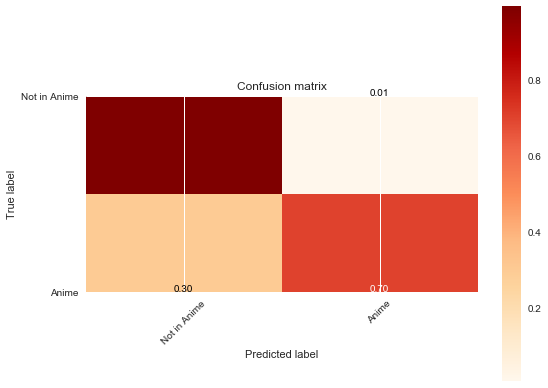

In [926]:
import itertools
pred = rfc_anime_full.predict(X_ent)
cm = confusion_matrix(y_anime, pred)
# tn, fp, fn, tp = cm

plot_confusion_matrix(cm, ["Not in Anime", "Anime"], normalize = 'all', cmap = "OrRd")
cm.ravel()

In [828]:
sorted(list(zip(rfc_Anime.feature_importances_, feats_ent)))

[(0.0019259397482239524, 'would'),
 (0.001936017634228288, 'least'),
 (0.002470192397232392, 'watch'),
 (0.002532240486803361, 'ever'),
 (0.002547761063435647, 'series'),
 (0.0025504744281263474, 'first'),
 (0.0025610307061039116, 'without'),
 (0.0026262961771151934, 'favorite'),
 (0.002656172822848171, 'watched'),
 (0.0026658907350136356, 'show'),
 (0.0027046193951050183, 'nice'),
 (0.0027279573921246626, 'dark'),
 (0.0027356562358888544, 'movie'),
 (0.002737399811209283, 'find'),
 (0.002776696475035548, 'though'),
 (0.0027795679941952202, 'kid'),
 (0.002817705283690343, 'friend'),
 (0.0028571892663975273, 'story'),
 (0.002857867868980416, 'around'),
 (0.002896965776452426, 'big'),
 (0.0029352875519486144, 'death'),
 (0.002986692922835178, 'deadpool'),
 (0.0030444346908095987, 'fan'),
 (0.003066157556095549, 'seems'),
 (0.003191121946110235, 'real'),
 (0.003203857522168424, 'issue'),
 (0.0032107977325530157, 'next'),
 (0.003226640623959252, 'keep'),
 (0.0032403919811429495, 'go'),
 (0

In [877]:
rfc_anime_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_anime_full.fit(X_ent, y_anime)
rfc_anime_full.oob_score

True

### Movies

In [829]:
y_mov = dummiezed['Subreddit_movies']
X_train_mov, X_test_mov, y_train_mov, y_test_mov = train_test_split(X_ent, y_mov, test_size=0.20)

In [830]:
rfc_movies =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_movies.fit(X_train_mov, y_train_mov)
print(cross_val_score(rfc_movies, X_test_mov, y_test_mov, cv=3, scoring = 'f1'))


[0.70454768 0.7005036  0.70818893]


In [705]:
sorted(list(zip(rfc_movies.feature_importances_, feats_ent)))

[(0.001403620912998328, 'series'),
 (0.001740921831805964, 'issue'),
 (0.0017828802796314334, 'top'),
 (0.0018521068027143354, 'list'),
 (0.0019430307683401407, 'friend'),
 (0.0020692656790906026, 'real'),
 (0.002258643705692588, 'give'),
 (0.0022642912100589705, 'big'),
 (0.0022818999334947966, 'would'),
 (0.002336700935434691, 'much'),
 (0.0023508334783137776, 'may'),
 (0.002380124708112273, 'time'),
 (0.0024404382579959407, 'find'),
 (0.0025315895616330863, 'first'),
 (0.0025508657214500124, 'least'),
 (0.0026181776352309093, 'show'),
 (0.002635806209294967, 'watched'),
 (0.0026367112722521903, 'yet'),
 (0.002681907217847862, 'next'),
 (0.002686716251632627, 'might'),
 (0.002760740035037937, 'though'),
 (0.002764829910514407, 'maybe'),
 (0.0028028283570627087, 'gt'),
 (0.0028508705739682906, 'got'),
 (0.002915616057085029, 'since'),
 (0.0029720502734763765, 'watching'),
 (0.002996291475283599, 'part'),
 (0.003029434595458059, 'without'),
 (0.0030326606546654936, 'around'),
 (0.00306

In [876]:
rfc_movies_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_movies_full.fit(X_ent, y_mov)
rfc_movies_full.oob_score

True

Normalized confusion matrix
[[0.98410128 0.01589872]
 [0.28561848 0.71438152]]


array([259539,   4193,  26831,  67109])

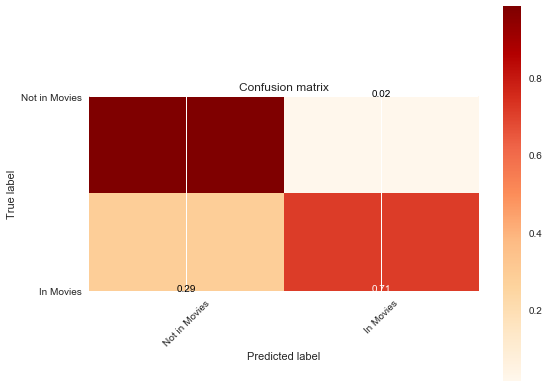

In [925]:
pred = rfc_movies_full.predict(X_ent)
cm = confusion_matrix(y_mov, pred)
# tn, fp, fn, tp = cm

plot_confusion_matrix(cm, ['Not in Movies', 'In Movies'], normalize = 'all', cmap = "OrRd")
cm.ravel()

### Potter

In [831]:
y_potter = dummiezed['Subreddit_harrypotter']
X_train_pot, X_test_pot, y_train_pot, y_test_pot = train_test_split(X_ent, y_potter, test_size=0.20)

In [834]:
rfc_potter =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_potter.fit(X_train_pot, y_train_pot)
print(cross_val_score(rfc_potter, X_test_pot, y_test_pot, cv=3, scoring = 'f1'))


[0.71890475 0.69332532 0.72976921]


In [706]:
sorted(list(zip(rfc_potter.feature_importances_, feats_ent)))

[(0.0010064522848316282, 'list'),
 (0.001191741697643826, 'story'),
 (0.0012519985819260317, 'everyone'),
 (0.0013048960463962673, 'never'),
 (0.0014473555336534086, 'album'),
 (0.0014596371375291582, 'real'),
 (0.0016130201268077884, 'nice'),
 (0.0017582170872400909, 'need'),
 (0.0018951102238570704, 'put'),
 (0.0019201720873810186, 'point'),
 (0.001984889231058927, 'maybe'),
 (0.002074880947950682, 'dark'),
 (0.0021415284536143537, 'series'),
 (0.0021508783514040584, 'song'),
 (0.0022351072581855967, 'back'),
 (0.002311627441452775, 'show'),
 (0.0023219156774763588, 'top'),
 (0.0023739304020602174, 'much'),
 (0.0024644471439370665, 'friend'),
 (0.002509970343186848, 'go'),
 (0.002564249806861119, 'kanye'),
 (0.0027026256581880186, 'could'),
 (0.002741427522284395, 'anything'),
 (0.002749279961636737, 'already'),
 (0.0027723874099916256, 'give'),
 (0.0027774070955964986, 'anyone'),
 (0.0028636059392667303, 'deadpool'),
 (0.0028842687440024926, 'long'),
 (0.002962971370891851, 'first')

In [875]:
rfc_potter_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_potter_full.fit(X_ent, y_potter)
rfc_potter_full.oob_score

True

Normalized confusion matrix
[[0.99861673 0.00138327]
 [0.30885489 0.69114511]]


array([324867,    450,   9993,  22362])

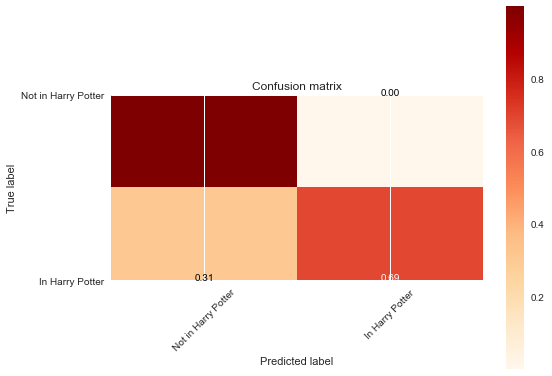

In [927]:
pred = rfc_potter_full.predict(X_ent)
cm = confusion_matrix(y_potter, pred)
# tn, fp, fn, tp = cm

plot_confusion_matrix(cm, ['Not in Harry Potter', 'In Harry Potter'], normalize = 'all', cmap = "OrRd")
cm.ravel()

### comic books

In [835]:
y_comic = dummiezed['Subreddit_comicbooks']
X_train_com, X_test_com, y_train_com, y_test_com = train_test_split(X_ent, y_comic, test_size=0.20)

In [836]:
rfc_comic =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_comic.fit(X_train_com, y_train_com)

print(cross_val_score(rfc_comic, X_test_com, y_test_com, cv=3, scoring = 'f1'))


[0.72643424 0.73239437 0.71590909]


In [707]:
sorted(list(zip(rfc_comic.feature_importances_, feats_ent)))

[(0.0012170337219487588, 'would'),
 (0.0013550025024346198, 'never'),
 (0.0017424600992424952, 'list'),
 (0.0018737175432099232, 'big'),
 (0.0019003686381861846, 'series'),
 (0.0019152049682429327, 'probably'),
 (0.0019550527753089213, 'maybe'),
 (0.0019907311581425064, 'part'),
 (0.002027455147597035, 'kid'),
 (0.002093679529584445, 'album'),
 (0.0020990125818565837, 'yet'),
 (0.0021387900388655655, 'watch'),
 (0.0022118718088710238, 'nice'),
 (0.0022120910694897987, 'though'),
 (0.002288285173213727, 'ever'),
 (0.0023298895857071606, 'got'),
 (0.0023380893521212005, 'give'),
 (0.0023617267953468936, 'without'),
 (0.0024200433513344327, 'anything'),
 (0.00250663126398992, 'back'),
 (0.0025307400529045515, 'find'),
 (0.0025352134672711767, 'show'),
 (0.00258656880738727, 'song'),
 (0.0026711160511910035, 'interesting'),
 (0.002695756342292675, 'friend'),
 (0.0027547735860618127, 'place'),
 (0.002797028555604432, 'favorite'),
 (0.002900678309771316, 'issue'),
 (0.002975049104328138, 'th

In [874]:
rfc_comic_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_comic_full.fit(X_ent, y_comic)
rfc_comic_full.oob_score

True

Normalized confusion matrix
[[0.99439481 0.00560519]
 [0.25995853 0.74004147]]


array([305316,   1721,  13163,  37472])

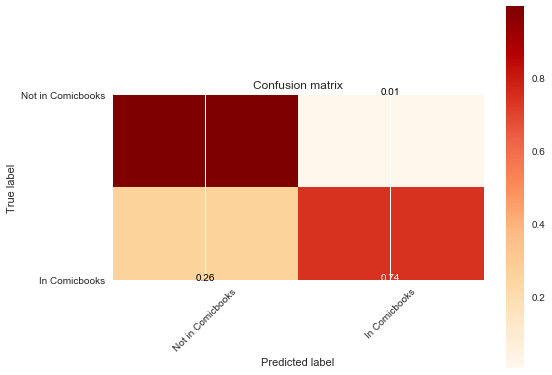

In [928]:
pred = rfc_comic_full.predict(X_ent)
cm = confusion_matrix(y_comic, pred)
# tn, fp, fn, tp = cm

plot_confusion_matrix(cm, ['Not in Comicbooks', 'In Comicbooks'], normalize = 'all', cmap = "OrRd")
cm.ravel()

### music

In [837]:
y_music = dummiezed['Subreddit_music']
X_train_mus, X_test_mus, y_train_mus, y_test_mus = train_test_split(X_ent, y_music, test_size=0.20)

In [838]:
rfc_music =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_music.fit(X_train_mus, y_train_mus)
print(cross_val_score(rfc_music, X_test_mus, y_test_mus, cv=3, scoring = 'f1'))


[0.74276123 0.73242437 0.73285045]


In [708]:
sorted(list(zip(rfc_music.feature_importances_, feats_ent)))

[(0.0017869163757743608, 'issue'),
 (0.0018700984616704423, 'top'),
 (0.0019801809156709286, 'series'),
 (0.0020735984555039625, 'list'),
 (0.0021285680893642755, 'friend'),
 (0.0022958046568867076, 'may'),
 (0.0023011086866430715, 'first'),
 (0.002319113946736228, 'real'),
 (0.002376778560513889, 'big'),
 (0.002390879864008463, 'time'),
 (0.002404518520484652, 'would'),
 (0.0024353435515287684, 'give'),
 (0.0024754134769212153, 'much'),
 (0.0024874856637312685, 'show'),
 (0.0025006641891809206, 'yet'),
 (0.002547022288130402, 'watched'),
 (0.0026434666726064754, 'might'),
 (0.0026490942952888084, 'find'),
 (0.0027187831170608022, 'next'),
 (0.002792284325880172, 'gt'),
 (0.0028034032330933587, 'though'),
 (0.002874444558065364, 'watch'),
 (0.0029066912555255893, 'least'),
 (0.0029286737214296098, 'part'),
 (0.0029849229542135342, 'long'),
 (0.0030236149422129786, 'since'),
 (0.0030460755248866976, 'maybe'),
 (0.003056483334509296, 'got'),
 (0.003222443943801604, 'watching'),
 (0.00322

In [873]:
rfc_music_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_music_full.fit(X_ent, y_music)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

Normalized confusion matrix
[[0.99681302 0.00318698]
 [0.26505098 0.73494902]]


array([313715,   1003,  11385,  31569])

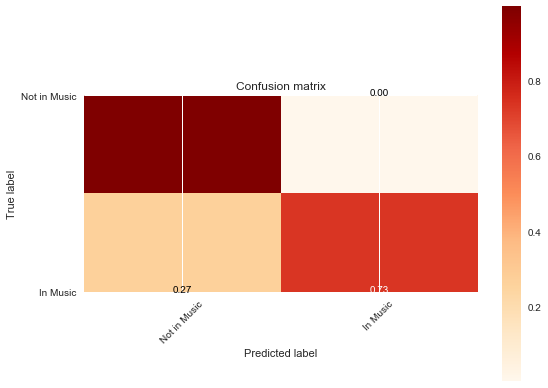

In [929]:
pred = rfc_music_full.predict(X_ent)
cm = confusion_matrix(y_music, pred)
# tn, fp, fn, tp = cm

plot_confusion_matrix(cm, ['Not in Music', 'In Music'], normalize = 'all', cmap = "OrRd")
cm.ravel()

### Star Wars

In [839]:
y_sw = dummiezed['Subreddit_starwars']
X_train_sw, X_test_sw, y_train_sw, y_test_sw = train_test_split(X_ent, y_sw, test_size=0.20)

In [841]:
rfc_sw =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None)
rfc_sw.fit(X_train_sw, y_train_sw)
print(cross_val_score(rfc_sw, X_test_sw, y_test_sw, cv=3, scoring = 'f1'))


[0.55235658 0.57070279 0.55206329]


In [709]:
sorted(list(zip(rfc_sw.feature_importances_, feats_ent)))

[(0.0018883867079122405, 'watch'),
 (0.002402417322113523, 'first'),
 (0.002635694615647043, 'never'),
 (0.0026583637637896773, 'maybe'),
 (0.0026868319312578497, 'already'),
 (0.002795277378705344, 'place'),
 (0.0028650956881119604, 'need'),
 (0.002960796084421828, 'top'),
 (0.0030472925757544555, 'gt'),
 (0.00308114708821017, 'long'),
 (0.003081930128704121, 'might'),
 (0.0031708025007824185, 'friend'),
 (0.0032525027793922413, 'part'),
 (0.0032636007759553596, 'movie'),
 (0.003275628445189702, 'death'),
 (0.0032845304666912793, 'nice'),
 (0.0033365632859287775, 'mean'),
 (0.003342241123668507, 'time'),
 (0.0033748749688834435, 'story'),
 (0.0035139889205014676, 'deadpool'),
 (0.003541988478582283, 'though'),
 (0.0035899031855376328, 'year'),
 (0.0036078072348049895, 'list'),
 (0.0036233504965513703, 'dark'),
 (0.0036283238887267876, 'since'),
 (0.0036929324072138394, 'keep'),
 (0.003737762552958234, 'real'),
 (0.003762152477073564, 'big'),
 (0.003785650578403294, 'issue'),
 (0.00381

In [872]:
y_sw = dummiezed['Subreddit_starwars']
rfc_sw_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_sw_full.fit(X_ent, y_sw)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

Normalized confusion matrix
[[0.90514365 0.09485635]
 [0.99653117 0.00346883]]


array([284865,  29853,  42805,    149])

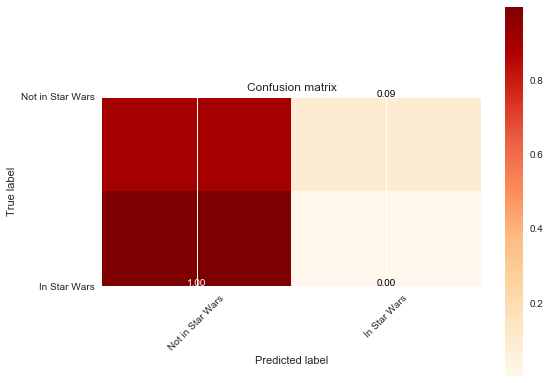

In [930]:
pred = rfc_sw_full.predict(X_ent)
cm = confusion_matrix(y_sw, pred)
# tn, fp, fn, tp = cm

plot_confusion_matrix(cm, ['Not in Star Wars', 'In Star Wars'], normalize = 'all', cmap = "OrRd")
cm.ravel()

## Create models fit to all text data to use predict

In [887]:
Test_strings = ['Little Witch Academia is the best anime ever written. I love to watch it at night on netflix. its just like harry potter for weebs']
lsttest=piped(Test_strings)
vectors = tfidf_vectorizer.transform(lsttest)
vectors.shape
rfc_anime_full.predict_proba(vectors)

array([[0.98, 0.02]])

In [939]:
Test_string = ['Little Witch Academia is the best anime ever written. its just like harry potter for weebs']
# X_ent = tfidf_vectorizer.fit_transform(dummiezed['Tokelems']).toarray()
StarWarsstring = ['Did you ever hear the Tragedy of Darth Plagueis the wise? I thought not. Its not a story the Jedi would tell you. Its a Sith legend. Darth Plagueis was a Dark Lord of the Sith, so powerful and so wise he could use the Force to influence the midichlorians to create life... He had such a knowledge of the dark side that he could even keep the ones he cared about from dying. The dark side of the Force is a pathway to many abilities some consider to be unnatural. He became so powerful... the only thing he was afraid of was losing his power, which eventually, of course, he did. Unfortunately, he taught his apprentice everything he knew, then his apprentice killed him in his sleep. Its ironic he could save others from death, but not himself. - Sheev Palpatine']

def which_ent_sub(Test_strings):
    '''
    parameters
    ------------------
    Test_strings : string of text in a list format that you want to use the predictor on
    
    returns
    -------------
    list(zip(model_names, probs)): list of tuples containing the model names and their
                                   respective false and true probabilities for being in that topic
    '''
    lsttest = piped(Test_strings)
    print(lsttest)
    model_names = ['Anime', 'Movies', 'Comic', 'Music', 'Star Wars', 'Harry Potter']

    vectors = tfidf_vectorizer.transform(lsttest)
    print(vectors.shape)
    models_ent = [rfc_anime_full, rfc_movies_full, rfc_comic_full, rfc_music_full, rfc_sw_full, rfc_potter_full]
    probs = []
    preds = []
    for i in models_ent:
        probs.append(i.predict_proba(vectors))
        preds.append(i.predict(vectors))
    preds_models = (list(zip(preds, model_names)))
    for i in preds_models:
        if i[0][0]==1:
            return i
    

    return (list(zip(probs, model_names)))

res = which_ent_sub(Test_string)
res

['witch academia ever written harry potter weebs ']
(1, 160)


(array([1], dtype=uint8), 'Harry Potter')

In [935]:
df_entertainment.loc[df['Subreddit'] == 'starwars']

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?,tokelems
1446810,he died for our spins.. .,d02mzs9,starwars,entertainment,1.455672e+09,roccoshapiro,1.0,0.0,7303.0,2180.0,0.0,died spin
1446822,i do n't think he necessarily knows that has a...,d02qghe,starwars,entertainment,1.455677e+09,p3wp3wkachu,4.0,0.0,1.0,242.0,0.0,necessarily know connection luke though interp...
1446824,"both times i saw it , it seemed to me that mea...",d02skyc,starwars,entertainment,1.455680e+09,Friendly_B,1.0,0.0,234.0,2865.0,0.0,time seemed meant island child true would me...
1446829,the tie fighters flying over was a nice touch ...,d02kdfr,starwars,entertainment,1.455668e+09,ltsmiles,1.0,0.0,53952.0,20152.0,0.0,tie fighter flying nice touch well done
1446837,they sure did . https : //youtu.be/qds6re-3hgo,d01oq0x,starwars,entertainment,1.455608e+09,cyborgcommando0,1.0,0.0,63181.0,66452.0,1.0,3hgo
...,...,...,...,...,...,...,...,...,...,...,...,...
1825076,[ rogwa wodrata ] ( http : //starwars.wikia.co...,d01ydig,starwars,entertainment,1.455637e+09,Blackfire853,3.0,0.0,20445.0,32571.0,0.0,rogwa wodrata infact female
1825077,apparently that is [ rogwa ] ( http : //starwa...,d01y9tz,starwars,entertainment,1.455637e+09,Vaxis7,2.0,0.0,1.0,42095.0,0.0,apparently rogwa
1825100,[ it 's not going to last very long. ] ( https...,d01k2ik,starwars,entertainment,1.455597e+09,TrueMarksmens,10.0,0.0,552.0,14734.0,0.0,last long
1825101,there are pipe dreams and then there 's a drug...,d01k07s,starwars,entertainment,1.455597e+09,ARTIFICIAL_SAPIENCE,6.0,0.0,2.0,132422.0,1.0,pipe dream induced coma


In [ ]:
meta_model_names = ['Gaming', 'Entertainment', 'Humor', 'Learning', 'News', 'Television', 'Lifestyle']
tv_model_names = ['Community', 'Breaking Bad', 'Doctor Who','Game of Thrones', 'How I Met Your Mother', 'My Little Pony', 'Star Trek','The Walking Dead']
humor_model_names = ['Advice Animals', 'Circlejerk', 'Facepalm', 'Funny','ImGoingToHellForThis', 'Jokes']
gaming_model_names = ['Gaming', 'dota2', 'League of Legends', 'Minecraft', 'Pokemon', 'Skyrim','Starcraft', 'Team Fortress 2']
learning_model_names = ['AskScience', 'AskHistorians', 'Explain Like im 5','Science', 'Space', 'Today I Learned', 'You Should Know']
news_model_names = ['Conservative','Conspiracy', 'Libertarian', 'News', 'Offbeat', 'politics', 'truereddit', 'World News']
entertainment_model_names = ['Anime', 'Movies', 'Comic Books', 'Harry Potter', 'Music', 'Star Wars']
lifestyle_model_names = ['Drunk', 'Food', 'Frugal','Guns', 'Lifehacks', 'Motorcycle', 'ProgressPics', 'Sex']


meta_models = [rfc_meta_gaming, rfc_meta_entertainment,rfc_meta_humor, rfc_meta_learn, rfc_meta_news, rfc_meta_tv, rfc_meta_life]
tv_models = [rfc_community, rfc_breaking_bad, rfc_docwho,rfc_got,  rfc_himym, rfc_mlp, rfc_trek, rfc_twd]
humor_models = [rfc_advani, rfc_jerk, rfc_facepalm, rfc_funny, rfc_hell, rfc_jokes]
gaming_models = [rfc_gaming, rfc_dota, rfc_lol, rfc_mine, rfc_poke, rfc_skyrim, rfc_starcraft, rfc_tf2]
learning_models = [rfc_askscience, rfc_askhist, rfc_eli5, rfc_science, rfc_space, rfc_til, rfc_ysk]
news_models = [rfc_con, rfc_conspire, rfc_liber, rfc_news_sub, rfc_offbeat, rfc_poli, rfc_truereddit, rfc_worldnews]
entertainment_models = [rfc_Anime, rfc_movies, rfc_comic, rfc_potter, rfc_music, rfc_sw]
lifestyle_models = [rfc_drunk, rfc_food, rfc_frugal, rfc_guns, rfc_lifehacks, rfc_moto, rfc_progress, rfc_sex]

In [816]:
X_ent = tfidf_vectorizer.fit_transform(df_entertainment['tokelems']).toarray()


In [818]:
X_ent.shape

(357672, 110)

In [271]:
anime_feat_importances = list(zip(feats, rfc_Anime.feature_importances_))
anime_feat_importances
Sort_Tuple(anime_feat_importances)

[('wanted', 0.0015095779329750236),
 ('yet', 0.0016172635948470946),
 ('use', 0.0018259751811389256),
 ('trying', 0.0019082351514213547),
 ('question', 0.0019259397482239524),
 ('getting', 0.001936017634228288),
 ('seems', 0.00213940147124929),
 ('top', 0.0023144481523114037),
 ('said', 0.0024239926127573594),
 ('place', 0.002470192397232392),
 ('dark', 0.002532240486803361),
 ('may', 0.002547761063435647),
 ('else', 0.0025504744281263474),
 ('put', 0.0025610307061039116),
 ('stuff', 0.0026122491152872325),
 ('done', 0.0026262961771151934),
 ('since', 0.0026490269958241593),
 ('please', 0.002656172822848171),
 ('without', 0.002662140866728492),
 ('week', 0.002664197415827794),
 ('mean', 0.0026658907350136356),
 ('kid', 0.0027046193951050183),
 ('big', 0.0027279573921246626),
 ('hope', 0.0027356562358888544),
 ('edit', 0.002737399811209283),
 ('whole', 0.0027460484928819346),
 ('nothing', 0.002776696475035548),
 ('game', 0.0027795679941952202),
 ('enough', 0.002817705283690343),
 ('next

In [273]:
movies_feat_importances = list(zip(feats, rfc_movies.feature_importances_))
Sort_Tuple(movies_feat_importances)

[('may', 0.001403620912998328),
 ('whole', 0.0016491691553770398),
 ('fuck', 0.001740921831805964),
 ('old', 0.0017828802796314334),
 ('girl', 0.0018521068027143354),
 ('enough', 0.0019430307683401407),
 ('trying', 0.002054276925624185),
 ('looking', 0.0020692656790906026),
 ('everything', 0.002258643705692588),
 ('around', 0.0022642912100589705),
 ('question', 0.0022818999334947966),
 ('stuff', 0.002298676551723636),
 ('seems', 0.0023205925720921772),
 ('interesting', 0.002336700935434691),
 ('gt', 0.0023508334783137776),
 ('oh', 0.002380124708112273),
 ('edit', 0.0024404382579959407),
 ('wanted', 0.0024650289855849385),
 ('reason', 0.002481847357606721),
 ('top', 0.002495940690944012),
 ('else', 0.0025315895616330863),
 ('sound', 0.002546938375876005),
 ('getting', 0.0025508657214500124),
 ('without', 0.002602859211740182),
 ('mean', 0.0026181776352309093),
 ('please', 0.002635806209294967),
 ('real', 0.0026367112722521903),
 ('keep', 0.002681907217847862),
 ('harry', 0.0026867162516

In [334]:
potter_feat_importances = list(zip(feats, rfc_potter.feature_importances_))
Sort_Tuple(potter_feat_importances)

[('girl', 0.0010064522848316282),
 ('watching', 0.0011212279073816124),
 ('next', 0.001191741697643826),
 ('wait', 0.0012108164455115406),
 ('deadpool', 0.0012519985819260317),
 ('song', 0.0012856061723545754),
 ('war', 0.0012946835012646034),
 ('kanye', 0.0013048960463962673),
 ('album', 0.0014473555336534086),
 ('looking', 0.0014596371375291582),
 ('kid', 0.0016130201268077884),
 ('star', 0.001706822857040336),
 ('issue', 0.0017582170872400909),
 ('without', 0.0017700979740110324),
 ('long', 0.0018951102238570704),
 ('list', 0.0019201720873810186),
 ('second', 0.0019552313172118392),
 ('guess', 0.001984889231058927),
 ('big', 0.002074880947950682),
 ('may', 0.0021415284536143537),
 ('music', 0.0021508783514040584),
 ('trying', 0.0021578909339079917),
 ('anything', 0.0022351072581855967),
 ('scene', 0.002306383897168459),
 ('mean', 0.002311627441452775),
 ('old', 0.0023219156774763588),
 ('interesting', 0.0023739304020602174),
 ('start', 0.0023987586109842753),
 ('two', 0.002431729708

In [335]:
comic_feat_importances = list(zip(feats, rfc_comic.feature_importances_))
Sort_Tuple(comic_feat_importances)

[('question', 0.0012170337219487588),
 ('trying', 0.0012848969483462435),
 ('kanye', 0.0013550025024346198),
 ('reason', 0.001451035805086672),
 ('use', 0.0015397762383011283),
 ('watched', 0.001664165256506852),
 ('whole', 0.0017135108298280196),
 ('girl', 0.0017424600992424952),
 ('around', 0.0018737175432099232),
 ('may', 0.0019003686381861846),
 ('little', 0.0019152049682429327),
 ('guess', 0.0019550527753089213),
 ('least', 0.0019907311581425064),
 ('game', 0.002027455147597035),
 ('album', 0.002093679529584445),
 ('real', 0.0020990125818565837),
 ('place', 0.0021387900388655655),
 ('kid', 0.0022118718088710238),
 ('nothing', 0.0022120910694897987),
 ('dark', 0.002288285173213727),
 ('watching', 0.0023280958132198683),
 ('far', 0.0023298895857071606),
 ('everything', 0.0023380893521212005),
 ('said', 0.0023537400971738675),
 ('put', 0.0023617267953468936),
 ('another', 0.0024200433513344327),
 ('anything', 0.00250663126398992),
 ('edit', 0.0025307400529045515),
 ('mean', 0.0025352

In [336]:
music_feat_importances = list(zip(feats, rfc_music.feature_importances_))
Sort_Tuple(music_feat_importances)

[('whole', 0.001658746004623978),
 ('fuck', 0.0017869163757743608),
 ('old', 0.0018700984616704423),
 ('may', 0.0019801809156709286),
 ('trying', 0.0020020094910338185),
 ('girl', 0.0020735984555039625),
 ('enough', 0.0021285680893642755),
 ('seems', 0.002292970643555627),
 ('gt', 0.0022958046568867076),
 ('else', 0.0023011086866430715),
 ('looking', 0.002319113946736228),
 ('stuff', 0.002326963145763608),
 ('wanted', 0.002332423692806541),
 ('around', 0.002376778560513889),
 ('oh', 0.002390879864008463),
 ('question', 0.002404518520484652),
 ('without', 0.002412903605235169),
 ('everything', 0.0024353435515287684),
 ('interesting', 0.0024754134769212153),
 ('mean', 0.0024874856637312685),
 ('real', 0.0025006641891809206),
 ('week', 0.002516338964761949),
 ('please', 0.002547022288130402),
 ('sound', 0.0025601916994657707),
 ('said', 0.0025912615306651022),
 ('harry', 0.0026434666726064754),
 ('edit', 0.0026490942952888084),
 ('reason', 0.002675777732554554),
 ('keep', 0.00271878311706

In [337]:
sw_feat_importances = list(zip(feats, rfc_sw.feature_importances_))
Sort_Tuple(sw_feat_importances)

[('may', 0.0013492673494798636),
 ('fuck', 0.0018311777633957071),
 ('looking', 0.0018620745504932016),
 ('whole', 0.0019317388796537746),
 ('trying', 0.001953965194708815),
 ('everything', 0.0019869440469235024),
 ('enough', 0.0020708533116176337),
 ('old', 0.0021204819271644234),
 ('question', 0.0021982569143176377),
 ('week', 0.0022177956847730766),
 ('girl', 0.0022196714598355137),
 ('stuff', 0.0023921217540892156),
 ('real', 0.0024031757008816535),
 ('around', 0.002426484149950083),
 ('oh', 0.002441302639949137),
 ('edit', 0.002462199880336833),
 ('seems', 0.0024632020253085346),
 ('without', 0.0024778864786829703),
 ('interesting', 0.002485048908431802),
 ('reason', 0.0024924251013973657),
 ('sound', 0.0025426499945913126),
 ('mean', 0.0025485514232312604),
 ('getting', 0.002564927623657437),
 ('else', 0.0026431364671207587),
 ('wanted', 0.0026578534479224686),
 ('gt', 0.0026887401635715346),
 ('please', 0.00274470965968375),
 ('harry', 0.002762644458811812),
 ('top', 0.002830326

In [404]:
x_test = tfidf_vectorizer.transform(lsttest)
x_test
rfc_sw.predict(x_test)

array([0], dtype=uint8)

(10040, 158)
(300000, 158)


In [397]:
rfc_sw.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)>

In [217]:
depth_param = [1,2,3,4,5,6,7,8,9,10,11,12,None]
num_samples_param = np.arange(5,95,10)
parameters = {'max_depth' : depth_param,
             'min_samples_leaf' : num_samples_param,
             'max_features': ['auto', 'sqrt', 'log2']}
clf = GridSearchCV(RandomForestClassifier(), param_grid = parameters, cv=5, n_jobs=-1, scoring = 'f1')
clf.fit(X, y)
print('f1 Score: {:.3}'.format(clf.score(X,y)))
print(clf.best_params_)


KeyboardInterrupt: 

In [211]:
param_grid = { 
    'n_estimators': [30,40,50, 60],
#     'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5,10,20,30, None],
    'min_samples_leaf':[1,2,3,4,5],
#     'min_impurity_split' :[10**-7, 10**-6, 10**-5, 0],
    'max_leaf_nodes' : [10,100,None]
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)

/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-package

KeyboardInterrupt: 

In [183]:
import sklearn.metrics
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [89]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(rfc, X_train, y_train, cv =10))

KeyboardInterrupt: 

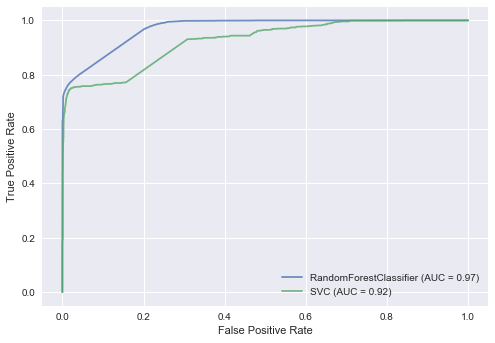

In [75]:

svc = SVC(random_state=42)
svc.fit(X, y)

ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X, y, ax=ax, alpha=0.8)
# svc_disp = plot_roc_curve(svc, X, y)




svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [124]:
print('Score: ', rfc.score(X_train, y_train))


Score:  0.9311


# beginning EDA make sure to dummyize subs

In [150]:
from collections import Counter
results = Counter()
df_entertainment['Tokelems'].apply(results.update)
# print(results)
print(len(results))

# set(['someone', 'ft.jgt', 'my', 'is', 'to', 'going', 'place', 'nickname'])

18029


In [639]:
# subs = Counter()
df['Subreddit'].unique()

array(['politics', 'libertarian', 'worldnews', 'offbeat', 'news',
       'truereddit', 'conspiracy', 'conservative', 'frugal',
       'motorcycles', 'sex', 'drunk', 'food', 'lifehacks', 'guns',
       'progresspics', 'askscience', 'science', 'explainlikeimfive',
       'askhistorians', 'youshouldknow', 'todayilearned', 'space',
       'circlejerk', 'facepalm', 'jokes', 'adviceanimals', 'funny',
       'imgoingtohellforthis', 'movies', 'harrypotter', 'music', 'anime',
       'comicbooks', 'starwars', 'doctorwho', 'community', 'breakingbad',
       'thewalkingdead', 'startrek', 'mylittlepony', 'gameofthrones',
       'himym', 'tf2', 'dota2', 'leagueoflegends', 'minecraft', 'pokemon',
       'gaming', 'skyrim', 'starcraft'], dtype=object)

In [151]:
resies = results.most_common(20)
resies = dict(resies)
resies_mod = dict()
for k, v in resies.items():
    if v<50000:
        resies_mod[k] = v

In [434]:
(Counter(df['meta'].values))

Counter({'news': 408716,
         'lifestyle': 384494,
         'learning': 271179,
         'humor': 382197,
         'entertainment': 379414,
         'television': 321794,
         'gaming': 578206})

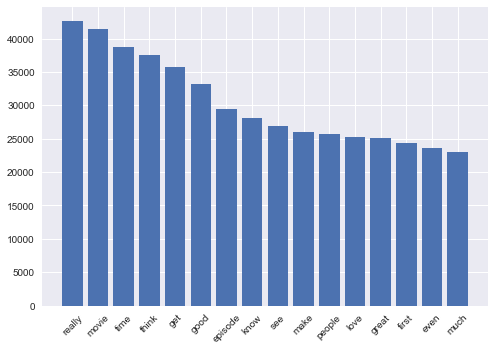

In [179]:

plt.bar(resies_mod.keys(), resies_mod.values())
plt.xticks(rotation=45)
plt.show()



In [73]:
from sklearn.feature_extraction import text
my_stop_words = list(text.ENGLISH_STOP_WORDS)
my_stop_words.append('www')
more_words_to_hate = ['http','things','thing', 'look', 'looking','lot','list','probably','just','year', 'https', 'well', 'time','like', 'maybe', 've', 'did','does', 'ca','does','got', 'times', 'would', 'need', 'actually', 'already', 'time', 'say', 'net', 'com', 'really', 
]
for i in more_words_to_hate:
    if i not in my_stop_words:
        my_stop_words.append(i)
        
        
new_stops = ['album','amazing', 'awesome', 'bad', 'best', 'better', 'bit', 'character', 'cool', 'day', 'end', 'episode', 'feel', 'film', 'going', 'good', 'great', 'know', 'life', 'little', 'll', 'looks', 'love', 'make', 'man', 'music', 'new', 'people', 'pretty', 'read', 'right', 'saw', 'scene', 'seen', 'sure', 'think', 'thought', 'want', 'wars', 'way', 'come', 'jpg','10','11','12', 'amp', 'days', 'edit', 'far', 'gets', 'fun', 'getting','let', 'later', 'makes', 'men', 'na','oh', 'op', 'post', 'reddit', 'said', 'remember', 'sorry', 'start', 'started', 'stop', 'tell', 'stuff', 'took', 'try','use', 'used', 'wait', 'wanted', 'week','went', 'yeah', 'yes', 'work', 'world']
        
for i in my_stop_words:
    new_stops.append(i)

In [82]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.965, min_df=.015, stop_words=new_stops)
tfidf_vectorizer.set_params(ngram_range =(1,2))
vectorized_y = tfidf_vectorizer.fit_transform(df_entertainment['Text'].values)

vectorized_y

<357672x46 sparse matrix of type '<class 'numpy.float64'>'
	with 348802 stored elements in Compressed Sparse Row format>

In [80]:
tfidf_vectorizer.fit(df_entertainment['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.965,
                max_features=None, min_df=0.015, ngram_range=(1, 1), norm='l2',
                preprocessor=None, smooth_idf=True,
                stop_words=['album', 'amazing', 'awesome', 'bad', 'best',
                            'better', 'bit', 'character', 'cool', 'day', 'end',
                            'episode', 'feel', 'film', 'going', 'good', 'great',
                            'know', 'life', 'little', 'll', 'looks', 'love',
                            'make', 'man', 'music', 'new', 'people', 'pretty',
                            'read', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=new_stops)

features = tfidf.fit_transform(df_entertainment['Text']).toarray()

labels = df_entertainment['Subreddit']
features.shape

In [67]:
# tfidf_vectorizer.get_feature_names()[vectorized_y[0].indices[1]]


In [83]:
tfidf_vectorizer.get_feature_names()

['anime',
 'big',
 'black',
 'book',
 'characters',
 'dark',
 'deadpool',
 'death',
 'definitely',
 'doing',
 'fan',
 'favorite',
 'force',
 'fuck',
 'fucking',
 'gt',
 'guess',
 'guy',
 'harry',
 'hope',
 'imgur',
 'interesting',
 'kanye',
 'kind',
 'long',
 'movie',
 'movies',
 'myanimelist',
 'nice',
 'old',
 'place',
 'point',
 'real',
 'second',
 'series',
 'shit',
 'song',
 'star',
 'story',
 'trying',
 'watch',
 'watched',
 'watching',
 'years',
 'youtube',
 'youtube watch']

In [ ]:
X = df_entertainment.drop

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

# NMF

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

vectorized = tfidf_vectorizer.fit_transform(clean_df2['Text'])

In [14]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '00000',
 '0000000031',
 '0000000642',
 '00000031',
 '00001',
 '00001001',
 '0000110',
 '00001g',
 '0001',
 '00026',
 '0004',
 '00063',
 '000bike',
 '000pull',
 '000sqft',
 '001',
 '00100000',
 '0011',
 '0015',
 '001c',
 '001jpg',
 '002',
 '003',
 '0033',
 '004',
 '005',
 '006225133476456637497',
 '007',
 '0079',
 '0080',
 '00800',
 '0088',
 '008jpg',
 '009',
 '00am',
 '00cst',
 '00gmt',
 '00pm',
 '00s',
 '01',
 '010',
 '01000001',
 '0103',
 '01100101',
 '01101000',
 '01101100',
 '01101111',
 '011915',
 '013',
 '014',
 '0140',
 '015',
 '016',
 '017',
 '01h29m41s',
 '01h41m51s',
 '01jpg',
 '01k',
 '02',
 '020',
 '021',
 '02102016',
 '0217',
 '0225',
 '0227',
 '023',
 '025',
 '028',
 '02933',
 '02937',
 '02fo',
 '02h13m39s',
 '02h26m08s',
 '03',
 '03231',
 '033',
 '0343',
 '036',
 '037',
 '038',
 '039',
 '03c12578',
 '03h10m20s',
 '03x0bu2w9hi',
 '04',
 '04042010',
 '042',
 '04e24f49b4d7b52aamp',
 '04e88fed000005dc',
 '04gif',
 '04jpg',
 '04mnf1ydnxi',
 '04putin',
 '05',


In [29]:
from sklearn.decomposition import NMF

model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(vectorized)
H = model.components_

def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(vectorized)
    W = nmf.transform(vectorized)
    H = nmf.components_
    return nmf.reconstruction_err_

In [28]:
vectorized

<2497636x49076 sparse matrix of type '<class 'numpy.float64'>'
	with 34722856 stored elements in Compressed Sparse Row format>

Text(0, 0.5, 'Reconstruction Errror')

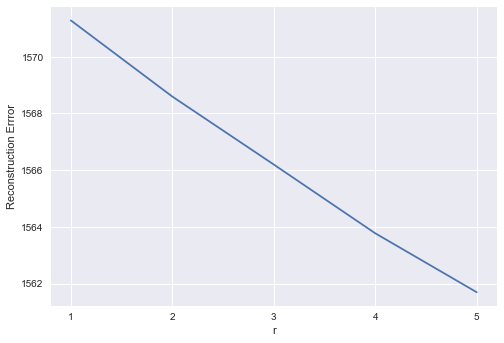

In [30]:
error = [fit_nmf(i) for i in range(1,6)]
plt.plot(range(1,6), error)
plt.xticks(range(1, 6))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

# Random Forest 

In [46]:
clean_df = clean_df.dropna(axis=0)

In [97]:
df_select = clean_df.loc[clean_df['Subreddit'] == 'entertainment']
df_select

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
1306620,wait see whoop intergalact alien butt rogu who...,d02nuw8,movies,entertainment,1.455673e+09,cmonster1697,1.0,0.0,488.0,8426.0,0.0
1306621,amaz cinematograph best ever,d02q51i,movies,entertainment,1.455676e+09,BrodoFagginsIsMyName,1.0,0.0,1.0,457.0,0.0
1306622,final life chang,d02uuym,movies,entertainment,1.455684e+09,BrodoFagginsIsMyName,3.0,0.0,1.0,457.0,0.0
1306623,awesom thank,d02ftgc,movies,entertainment,1.455661e+09,JeopardyThis,3.0,0.0,1.0,-7.0,0.0
1306624,tom cruis charact john anderton kidnap pre-cog...,465qz3,movies,entertainment,1.455672e+09,tangowhiskey33,16.0,0.0,7346.0,6138.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1664682,love,d026lj4,harrypotter,entertainment,1.455648e+09,elbowsss,2.0,0.0,2212.0,8637.0,1.0
1664683,type ra hope manag get select current ras grea...,d02qfaf,harrypotter,entertainment,1.455677e+09,DEP61,2.0,0.0,5581.0,13488.0,0.0
1664684,bulletin board month p http iimgurcom7h3pfuyjpg,d02rem2,harrypotter,entertainment,1.455678e+09,laneebird,2.0,0.0,43.0,8.0,0.0
1664685,excel would pleas find first day great job,d02ecuj,harrypotter,entertainment,1.455659e+09,GoodniteMush,1.0,0.0,1.0,681.0,0.0


In [154]:
X = df_select.drop(['Subreddit', 'ID'], axis =1)
y = df_select['Subreddit']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

In [152]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=s_stop, max_features =5000 )
vec_X_train = tfidf_vectorizer.fit_transform(X_train)
vec_X_test = tfidf_vectorizer.fit_transform(X_test)

In [153]:
# Train and fit model                                                   
rf = RandomForestClassifier(random_state=0,n_jobs=10, max_features = 'sqrt')

rf.fit(vec_X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(vec_X_test)
print('Accuracy score: {:.3}'.format(rf.score(vec_X_test, y_test)))

Accuracy score: 0.224


In [ ]:
full_class_names = ['entertainment_anime.csv', 'entertainment_comicbooks.csv', 'entertainment_harrypotter.csv', 'entertainment_movies.csv', 'entertainment_music.csv', 'entertainment_starwars.csv', 'gaming_dota2.csv','gaming_gaming.csv', 'gaming_leagueoflegends.csv','gaming_minecraft.csv','gaming_pokemon.csv','gaming_skyrim.csv','gaming_starcraft.csv', 'gaming_tf2.csv','humor_adviceanimals.csv', 'humor_circlejerk.csv', 'humor_facepalm.csv','humor_funny.csv','humor_imgoingtohellforthis.csv','humor_jokes.csv', 'learning_askhistorians.csv','learning_askscience.csv','learning_explainlikeimfive.csv', 'learning_science.csv', 'learning_space.csv', 'learning_todayilearned.csv', 'learning_youshouldknow.csv', 'lifestyle_drunk.csv', 'lifestyle_food.csv', 'lifestyle_frugal.csv', 'lifestyle_guns.csv','lifestyle_lifehacks.csv','lifestyle_motorcycles.csv','lifestyle_progresspics.csv', 'lifestyle_sex.csv','news_conservative.csv','news_conspiracy.csv', 'news_libertarian.csv', 'news_news.csv','news_offbeat.csv','news_politics.csv', 'news_truereddit.csv', 'news_worldnews.csv','television_breakingbad.csv','television_community.csv', 'television_doctorwho.csv', 'television_gameofthrones.csv', 'television_himym.csv', 'television_mylittlepony.csv','television_startrek.csv', 'television_thewalkingdead.csv']


In [135]:
enter_names = ['anime', 'comicbooks', 'harrypotter', 'movies', 'music', 'starwars']



KeyError: 'anime'

In [55]:
s_stop = set(stopwords.words())
print(len(s_stop))
new_stops = ['2015ref','publisherspage190ref','volume9', 'issue2','005', '1671', '2015', 'jpgthumbemerg', 'jpgthumbrightth', 'logo', 'page7','logo.png','2015.ref', 'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-', 'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 'refimprovedatemay','ligatureligatur', 'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob','baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद', 'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम', 'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन', 'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल', 'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत', 'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष', 'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत', 'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर', 'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक', 'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन', 'हर', 'हरण', 'ἀλλ']
for i in new_stops:
    s_stop.add(i)
    
    
print(len(s_stop))




6255
6471


In [92]:
vectorizer = CountVectorizer(stop_words=s_stop)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
y_train_vec = vectorizer.transform(y_train)
rf = RandomForestClassifier(n_estimators=,
                           max_features='auto',
                           random_state=0,
                           oob_score=True)

rf.fit(X_train_vec, y_train)
rf.oob_score_
# print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
# print("Train Score: ", round(rf.score(X_train_vec,y_train)))
# print("Train Score: ", round(rf.score(X_test_vec,y_test)))
# print("Dic Size:", len(vectorizer.get_feature_names()))

ValueError: Number of labels=1673416 does not match number of samples=10

In [111]:
X = df_select['Text']
y = df_select['meta']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

1306620    entertainment
1306621    entertainment
1306622    entertainment
1306623    entertainment
1306624    entertainment
               ...      
1664682    entertainment
1664683    entertainment
1664684    entertainment
1664685    entertainment
1664686    entertainment
Name: meta, Length: 356493, dtype: object

In [110]:

# train = pd.read_csv('../input/train.csv').fillna(' ')
# test = pd.read_csv('../input/test.csv').fillna(' ')


KeyError: 'Text'

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer : i think obama should nominate som...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then. people o...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here 's a 1970 law review...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you 're trying to use a brand...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


# EDA and Exploratory Graphs

/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, "Histogram of users' link karma, removed outliers")

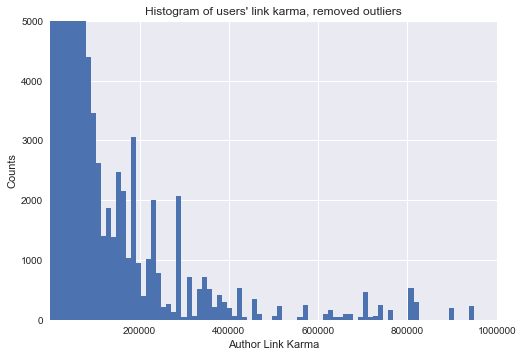

In [194]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
plt.ylim(0, 5000)
plt.xlim(5,1000000)
ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, removed outliers")

Text(0.5, 1.0, "Histogram of users' link karma, yscale log")

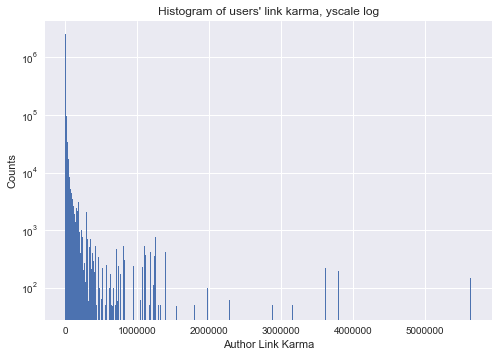

In [195]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
# plt.ylim(0, 5000)
# plt.xlim(5,1000000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, yscale log")

Text(0.5, 1.0, "Histogram of users' link karma, outliers removed yscale log")

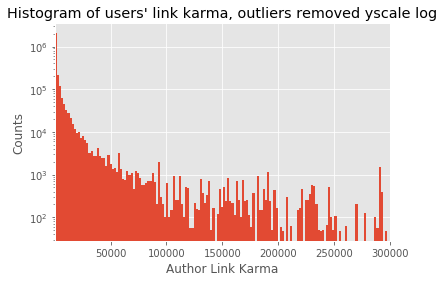

In [160]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 3000)
# plt.ylim()
plt.xlim(1,300000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, outliers removed yscale log")

Text(0.5, 1.0, "Histogram of users' comment karma, removed outliers")

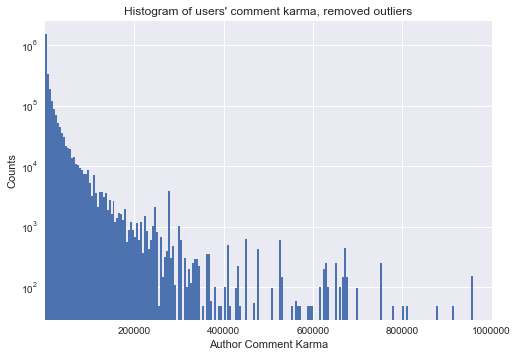

In [204]:
fig, ax = plt.subplots()
plt.hist(df.Author_Comment_Karma, bins = 500)
# plt.ylim(0, 5000)
plt.xlim(1,1000000)

ax.set_yscale('log')
ax.set_xlabel('Author Comment Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' comment karma, removed outliers")

(0, 1500000)

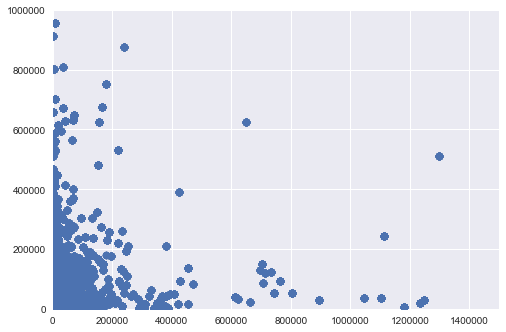

In [207]:
fig, ax = plt.subplots()

plt.scatter(df_test.Author_link_karma, df_test.Author_Comment_Karma)

# ax.set_yscale('')

ax.set_ylim(0, 1000000)
ax.set_xlim(0, 1500000)

Text(0.5, 1.0, 'Histogram of posts per hour of day')

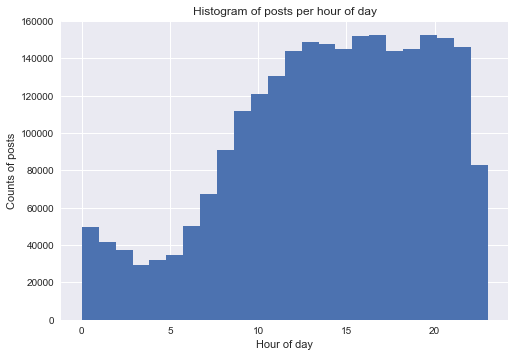

In [192]:
fig, ax = plt.subplots()

plt.hist(df_test.Time.dt.hour, bins = 24)
plt.style.use('seaborn')
ax.set_ylabel('Counts of posts')
ax.set_xlabel('Hour of day')
ax.set_title('Histogram of posts per hour of day')

In [1]:
df_test['Time'].dt.hour

NameError: name 'df_test' is not defined

In [205]:
df_test

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaim think obama nomin someon senat hold c...,d028c5d,politics,news,2016-02-16 13:25:06,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way process drag elect gop vote senat s...,d026od6,politics,news,2016-02-16 12:47:45,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republican alway battl sever case select amnesia,d026wk3,politics,news,2016-02-16 12:52:49,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,polit differ back peopl side least pretend rea...,d02a3k3,politics,news,2016-02-16 14:04:12,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,equal ridicul 1970 law review articl mcconnel ...,d025wad,politics,news,2016-02-16 12:30:13,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,woefulli bad sens direct use advic hand time p...,d02c1s1,minecraft,gaming,2016-02-16 14:46:51,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,charact hand first person invis look glitchi u...,464kj4,minecraft,gaming,2016-02-16 15:01:34,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,guess either shader use featur ad 18 glsl vers...,d02cxvk,minecraft,gaming,2016-02-16 15:06:52,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,guess tri use brand spank new graphic driver n...,d02ic1n,minecraft,gaming,2016-02-16 17:11:31,nothingl_,1.0,0.0,104.0,807.0,0.0


In [ ]:
import itertools

words = clean_df['Text'].str.lower().str.findall("\w+")
words = list(itertools.chain(words))
unique = set(words)
print(unique)

# PETER PREDICTIONS

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
group_names = ['Cities in USA', 'Biology', 'Articles abt Wikipedia', 'Music',
          'Cities in Japan', 'Pictures', 'Politics', 'TV & Movies',
          'Cities in USA', 'History']
with open('vectorizer.pk', 'rb') as fin:
    vectorizer = pickle.load(fin)
with open('sk_nmf.pk', 'rb') as fin:
    sk_nmf = pickle.load(fin)
print ("Please Enter Your Article:")
article = input()
my_dict = {"file_name": ["bozo.txt"], "contents": [article]}
new_df = pd.DataFrame.from_dict(my_dict)
X_new = vectorizer.transform(new_df['contents'])
W_new = sk_nmf.transform(X_new)
group_probs = W_new[0]
z = zip(group_names, group_probs)
z = sorted(z, key = lambda x: x[1], reverse=True)
for n, p in z:
    print (n + ":", p)